## Base Model Swarm
This is the third in a series of three notebooks for the ODSC presentation 'Harnessing GPT Assistants for Superior Model Ensembles: A Beginner's Guide to AI STacked-Classifiers' ODSC East -- Jason Merwin

In [5]:
import openai
import time
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from io import StringIO
import io
import json
import warnings

from config import OPENAI_API_KEY

warnings.filterwarnings('ignore', category=FutureWarning)

# define functions
def delete_all_agents():
    ''' Deletes all exising Assistants '''
    # Fetch the list of assistants
    my_assistants = client.beta.assistants.list(order="desc", limit=20)
    asst_ids = [asst.id for asst in my_assistants.data]
    print(f'Deleting {len(asst_ids)} assistants.')
    # Delete each assistant
    for asst_id in asst_ids:
        client.beta.assistants.delete(asst_id)
        print(f"Deleted assistant with ID: {asst_id}")
    print('Finished deleting all assistants')
    
def delete_all_assistant_files():
    ''' Deletes all exising files uploaded to client using API key '''
    # generate a files object
    files_object = client.files.list()
    # get a list comprehension
    file_ids = [file.id for file in files_object.data]
    print(f'Deleting {len(file_ids)} files.')
    #delete them all
    for file_id in file_ids:
        client.files.delete(file_id)
        print(f"Deleted file with ID: {file_id}")
        time.sleep(1)
    print('Finished deleting all files')   


def upload_csv(file_name):
    response = client.files.create(
        file=open(file_name, "rb"),
        purpose="assistants")
    print(response)
    file_id = response.id
    return file_id

def spin_up(target, base_instructions, file_id):
    # create assistant
    my_assistant = client.beta.assistants.create(
        instructions=base_instructions,
        name="agent",
        tools=[{"type": "code_interpreter"}],
        model="gpt-4-turbo-preview", #"gpt-4-1106-preview", # "gpt-4", # "gpt-3.5-turbo-1106", "gpt-4-turbo-preview"
        file_ids=file_id)
    message_string = "Please execute your ACTIONS on the csv file, the target field is " + target
    # Create a Thread
    thread = client.beta.threads.create()
    # Add a Message to a Thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content= message_string)
    # Run the Assistant
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=my_assistant.id)
    return my_assistant, thread, run 
    print('Finished creating Assistants')
    #assistant, thread, run = spin_up(n, base_instructions, file_id)    
    
def catch_response(assistant, thread, run):
    # Retrieve the run status
    run_status = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id)
    print('########################')
    print('Checking for response...')
    # Handle None response
    if run_status is None:
        print("No response yet")
        return None, None  # Return a tuple of None values to match the expected return type
    # Handle non-completed response
    if run_status.status != 'completed':
        print("Response status is not 'completed'")
        return None, None
    # Handle completed response
    if run_status.status == 'completed':
        messages = client.beta.threads.messages.list(
            thread_id=thread.id)
        contents = []  # Initialize an empty list to store contents
        # Loop through messages and process content based on role
        for msg in messages.data:
            role = msg.role
            try:
                content = msg.content[0].text.value
                print(f"{role.capitalize()}: {content}")
                contents.append(content)  # Append content to the list
            except AttributeError:
                # This will execute if .text does not exist
                print(f"{role.capitalize()}: [Non-text content, possibly an image or other file type]")
        return messages, contents  # Return messages and a list of contents
    else:
        print('Unable to retrieve message')
        return None, None

def create_dataframes_from_messages(messages, client):
    loop_dfs = []
    # Check if messages is None or messages.data is empty
    if messages is None or not messages.data:
        print("No messages data found.")
        return loop_dfs
    first_thread_message = messages.data[0]  # Accessing the first ThreadMessage
    message_ids = first_thread_message.file_ids
    # Loop through each file ID and create a DataFrame
    for file_id in message_ids:
        # Read the file content
        file_data = client.files.content(file_id)
        # Check if file_data is None
        if file_data is None:
            print(f"No content found for file_id: {file_id}")
            continue  # Skip this iteration and proceed with the next file_id
        file_data_bytes = file_data.read()
        file_like_object = io.BytesIO(file_data_bytes)
        # Create a DataFrame from the file-like object and append
        df = pd.read_csv(file_like_object)
        loop_dfs.append(df)
    return loop_dfs   

def calculate_model_accuracies(df):
    model_accuracy_dict = {}
    # Filter columns that contain probability predictions
    prediction_columns = [col for col in df.columns if "_status" in col]
    
    for col in prediction_columns:
        # Assuming binary classification with 0.5 threshold
        predicted_classes = df[col].apply(lambda x: 1 if x >= 0.5 else 0)
        actual_classes = df[f'{target}']
        # Calculate accuracy
        accuracy = accuracy_score(actual_classes, predicted_classes)
        # Extract model name from column name 
        model_name = col.split("_status")[0]
        model_accuracy_dict[model_name] = accuracy
    
    return model_accuracy_dict

def calculate_model_metrics(df, target):
    model_metrics_dict = {}
    # Filter columns that contain probability predictions
    prediction_columns = [col for col in df.columns if "_status" in col]

    for col in prediction_columns:
        # Assuming binary classification with 0.5 threshold
        predicted_classes = df[col].apply(lambda x: 1 if x >= 0.5 else 0)
        actual_classes = df[target]
        # Calculate accuracy, precision, recall, and F1-score
        accuracy = accuracy_score(actual_classes, predicted_classes)
        precision = precision_score(actual_classes, predicted_classes, zero_division=0)
        recall = recall_score(actual_classes, predicted_classes, zero_division=0)
        f1 = f1_score(actual_classes, predicted_classes, zero_division=0)
        # Extract model name from column name 
        model_name = col.split("_status")[0]
        # Store the metrics in a dictionary with the model name as key
        model_metrics_dict[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
  
    return model_metrics_dict

# Initialize API Session

In [6]:
# Instantiate the OpenAI client
client = openai.OpenAI(api_key=OPENAI_API_KEY)

# check training and testing data

In [7]:
#use the feature engineer output
encoded_train = pd.read_csv('meta_train_df.csv')
encoded_val = pd.read_csv('meta_val_df.csv')
target = 'Quality'

display(encoded_train.head())
display(encoded_val.head())

,row_id,Logi_prob,Deci_prob,KNei_prob,Rand_prob,Extr_prob,Supp_prob,Quality
0,0,0.807077,1,1.0,0.81,0.82,0.976517,1
1,1,0.888458,1,1.0,0.97,0.97,0.977460,1
2,2,0.509400,0,0.0,0.28,0.28,0.125335,0
3,3,0.707898,1,1.0,0.90,0.93,0.963616,1
4,4,0.829310,0,1.0,0.84,0.81,0.898430,1


,row_id,Logi_prob,Deci_prob,KNei_prob,Rand_prob,Extr_prob,Supp_prob,Quality
0,555,0.641120,1.0,0.72,0.686,0.644,0.829235,1
1,3491,0.666901,0.0,0.76,0.862,0.714,0.834491,0
2,527,0.603839,1.0,0.68,0.570,0.528,0.378980,0
3,3925,0.524097,1.0,1.00,0.732,0.788,0.936887,1
4,2989,0.015525,0.0,0.00,0.022,0.040,0.009707,0


# Create the Swarm

In [8]:
# first make sure any existing bots and files are cleaned up
delete_all_agents()   
delete_all_assistant_files()

Deleting 0 assistants.
Finished deleting all assistants
Deleting 0 files.
Finished deleting all files


In [9]:
# define model types and file names for iteration
model_types = ['Logistic_Regression', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'Random_Forest', 'Extra_Trees_Random_Forest', 'Support Vector Machine']

train_id = upload_csv(f'meta_train_df.csv')
val_id = upload_csv(f'meta_val_df.csv')
file_ids = [train_id, val_id]

agents = []

for i in model_types:
    print(f'Creating {i} assistant')
    
    #assign loop version of models and file names
    model = i
    print('provided these files')
    print(file_ids)
    instructions = f'''
    You are a data scientist who will build and test a meta model with data output from several base models in the provided csv files.
    When the user asks you to perform your ACTIONS, carry out the described ACTIONS on the provided files.
    The target variable is '{target}'.
    There is an id column to be maintained, unaltered and returned in the output called "row_id". It should be excluded when training the model.

    ACTIONS:

    1.The meta data has been prepared for training and testing a {model} classification model to predict the target variable '{target}'.
    2.Train a {model} classification model using default hyper-parameter values and cross validation on the training data {train_id}. 
    3.Use the trained model to get the '{target}' prediction probabilities from the provided validation data in file {val_id}. It should produce a class probability scores.
    4.Create Table 1 from the validation data class prediction probabilities. The table should have three columns: one for the target values in {val_id} called '{target}', one for the 'row_id' value, and a single column for the predicted status probability called '{model[:4]}_status'.
    5.Prepare Table 1 as a CSV file for the user to download.   
    6.Please do not respond until the table is ready for download.

    DO NOT:
    1. Do not return any images.
    2. Do not return any other tables besides Table 1.
    3. Do not include row_id as a feature in the training of the model.
    4. Do not respond before the validation table is ready for download.
    '''  

    # spin up for each model type and store return object
    assistant, thread, run = spin_up(f'{target}', instructions, file_ids) 
    agents.append((assistant, thread, run, model))  
    print()
    time.sleep(5)

FileObject(id='file-PD6JbXaLyO4baE7lgobkQgRl', bytes=196045, created_at=1714063567, filename='meta_train_df.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-GPstt5Gh3QMr0Yt2odQCt2D7', bytes=58394, created_at=1714063568, filename='meta_val_df.csv', object='file', purpose='assistants', status='processed', status_details=None)
Creating Logistic_Regression assistant
provided these files
['file-PD6JbXaLyO4baE7lgobkQgRl', 'file-GPstt5Gh3QMr0Yt2odQCt2D7']

Creating DecisionTreeClassifier assistant
provided these files
['file-PD6JbXaLyO4baE7lgobkQgRl', 'file-GPstt5Gh3QMr0Yt2odQCt2D7']

Creating KNeighborsClassifier assistant
provided these files
['file-PD6JbXaLyO4baE7lgobkQgRl', 'file-GPstt5Gh3QMr0Yt2odQCt2D7']

Creating Random_Forest assistant
provided these files
['file-PD6JbXaLyO4baE7lgobkQgRl', 'file-GPstt5Gh3QMr0Yt2odQCt2D7']

Creating Extra_Trees_Random_Forest assistant
provided these files
['file-PD6JbXaLyO4baE7lgobkQgRl', 'file-GPs

# Catch the Responses

In [10]:
# run a loop to catch the Agent responses
time.sleep(300) 

agent_responses = []
for assistant, thread, run, model, in agents:
    messages, content = catch_response(assistant, thread, run) 
    agent_responses.append((messages, content, model, assistant))
    time.sleep(10) 

########################
Checking for response...
Assistant: The actions have been executed as requested, and Table 1 is ready for download. You can download the CSV file containing the validation data class prediction probabilities using the link below:

[Download Table 1](sandbox:/mnt/data/table_1.csv)
User: Please execute your ACTIONS on the csv file, the target field is Quality
########################
Checking for response...
Assistant: The validation table, Table 1, is ready for download. You can download it using the following link: [table_1.csv](sandbox:/mnt/data/table_1.csv).
User: Please execute your ACTIONS on the csv file, the target field is Quality
########################
Checking for response...
Assistant: The table with the required validation data class prediction probabilities has been prepared and saved as a CSV file. You can download it using the following link: [validation_predictions.csv](sandbox:/mnt/data/validation_predictions.csv).
User: Please execute your AC

In [11]:
#extract dataframes and compile
df_list = []
for messages, content, model, assistant in agent_responses:
    dataframes = create_dataframes_from_messages(messages, client)
    assistant_id = assistant.id
    df_list.append([dataframes, model, assistant_id])

In [12]:
df_list

[[[     row_id  Quality  Logi_status
   0       555        1     0.832205
   1      3491        0     0.872928
   2       527        0     0.628834
   3      3925        1     0.957322
   4      2989        0     0.021040
   ..      ...      ...          ...
   795    1922        0     0.065397
   796     865        1     0.978932
   797    3943        1     0.978314
   798    1642        1     0.896622
   799    2483        1     0.913935
   
   [800 rows x 3 columns]],
  'Logistic_Regression',
  'asst_4Kvu0521yPVdJTGwH2Zt3pls'],
 [[     row_id  Quality  Deci_status
   0       555        1          1.0
   1      3491        0          1.0
   2       527        0          1.0
   3      3925        1          1.0
   4      2989        0          1.0
   ..      ...      ...          ...
   795    1922        0          1.0
   796     865        1          1.0
   797    3943        1          1.0
   798    1642        1          1.0
   799    2483        1          1.0
   
   [800 rows x 

In [13]:
# Initialize an empty dictionary
meta_results_df_dict = {}
failures = []

# Loop through and capture testing data output
for item in df_list:
    try:
        df1 = pd.DataFrame(item[0][0]) 
        if 'row_id' not in df1.columns:
            df1 = df1.reset_index().rename(columns={'index': 'row_id'})
        model = item[1]
        # Extract the first three letters of the model and the fold_id value
        key = model
        # Add the DataFrame to the dictionary with the generated key
        meta_results_df_dict[key] = df1
        
    except:
        assistant_model = item[1]
        failures.append([assistant_model])
        
# Display failed data returns
print('assistants which failed to return a scored training data dataframe:')
print(failures)

assistants which failed to return a scored training data dataframe:
[]


# Prepare Scored Validation Data 

In [14]:
# create a target df to join everything to
list_of_keys = list(meta_results_df_dict.keys())
first_key = list_of_keys[0]
meta_results_data = meta_results_df_dict[first_key]

# Loop through the DataFrames in the dictionary, joining each to the label
for key in meta_results_df_dict:
    if key != first_key and key not in failures:
        # get each dataframe
        cols_to_join = meta_results_df_dict[key]
        # Join with the initial DataFrame on 'row_id'
        meta_results_data = meta_results_data.merge(cols_to_join, on=['row_id', f'{target}'], how='left')
        print(f'joined to {key}')
        
display(meta_results_data)   

joined to DecisionTreeClassifier
joined to KNeighborsClassifier
joined to Random_Forest
joined to Extra_Trees_Random_Forest
joined to Support Vector Machine


,row_id,Quality,Logi_status,Deci_status,KNei_status,Rand_status,Extr_status,Supp_status
0,555,1,0.832205,1.0,0.6,0.79,0.72,0.919201
1,3491,0,0.872928,1.0,0.8,0.93,0.89,0.927678
2,527,0,0.628834,1.0,1.0,0.51,0.53,0.795189
3,3925,1,0.957322,1.0,1.0,0.90,0.90,0.909253
4,2989,0,0.021040,1.0,0.0,0.00,0.00,0.078752
...,...,...,...,...,...,...,...,...
795,1922,0,0.065397,1.0,0.0,0.04,0.00,0.059020
796,865,1,0.978932,1.0,1.0,1.00,1.00,0.906279
797,3943,1,0.978314,1.0,1.0,1.00,1.00,0.906332
798,1642,1,0.896622,1.0,1.0,1.00,0.99,0.927181


In [15]:
# save the meta training file
meta_results_data.to_csv('meta_results_data.csv', index=False)
meta_results_data_df = pd.read_csv('meta_results_data.csv')
accuracy_dict = calculate_model_metrics(meta_results_data_df, f'{target}')
meta_model_accuracy_df = pd.DataFrame.from_dict(accuracy_dict, orient='index').reset_index()
meta_model_accuracy_df.columns = ['Model', 'Accuracy_meta','precision_meta','recall_meta','f1_score_meta',]
meta_model_accuracy_df.to_csv('meta_model_accuracy.csv', index=False)
meta_model_accuracy_df

,Model,Accuracy_meta,precision_meta,recall_meta,f1_score_meta
0,Logi,0.90875,0.907500,0.909774,0.908636
1,Deci,0.49875,0.498750,1.000000,0.665555
2,KNei,0.89875,0.893564,0.904762,0.899128
3,Rand,0.90125,0.904040,0.897243,0.900629
4,Extr,0.89750,0.899244,0.894737,0.896985
5,Supp,0.90750,0.905237,0.909774,0.907500


In [16]:
# compare meta to base model metrics

accuracy_dict = calculate_model_metrics(meta_results_data_df, f'{target}')
meta_model_accuracy_df = pd.DataFrame.from_dict(accuracy_dict, orient='index').reset_index()
meta_model_accuracy_df.columns = ['Model', 'Accuracy_meta','precision_meta','recall_meta','f1_score_meta',]
meta_model_accuracy_df.to_csv('meta_model_accuracy.csv', index=False)

# save both rounds of performance outputs and join in third notebook for a graphic
base_model_accuracy_df = pd.read_csv('base_model_accuracy.csv')

result = pd.merge(base_model_accuracy_df, meta_model_accuracy_df, left_on='Model', right_on='Model', how='left')
result.to_csv('result.csv')
result = pd.read_csv('resultb.csv')
result

,Unnamed: 0,Model,Accuracy_base,precision_base,recall_base,f1_score_base,Accuracy_meta,precision_meta,recall_meta,f1_score_meta
0,0,Logi,0.79000,0.778313,0.809524,0.793612,0.91500,0.914787,0.914787,0.914787
1,1,Deci,0.87250,0.875949,0.867168,0.871537,0.87250,0.868486,0.877193,0.872818
2,2,KNei,0.89000,0.889724,0.889724,0.889724,0.90750,0.917738,0.894737,0.906091
3,3,Rand,0.89750,0.895262,0.899749,0.897500,0.92000,0.915633,0.924812,0.920200
4,4,Extr,0.90875,0.903465,0.914787,0.909091,0.91125,0.910000,0.912281,0.911139
5,5,Supp,0.90875,0.901478,0.917293,0.909317,0.92125,0.913793,0.929825,0.921739


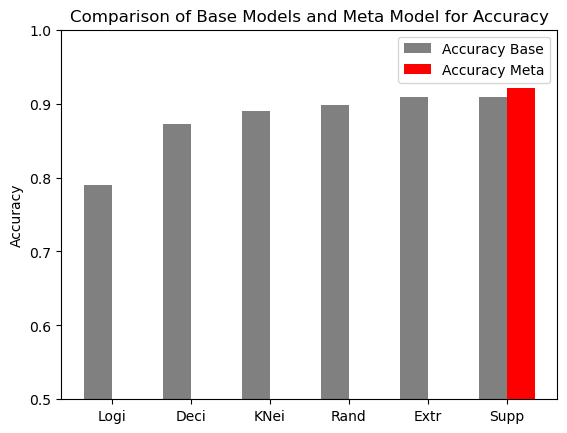

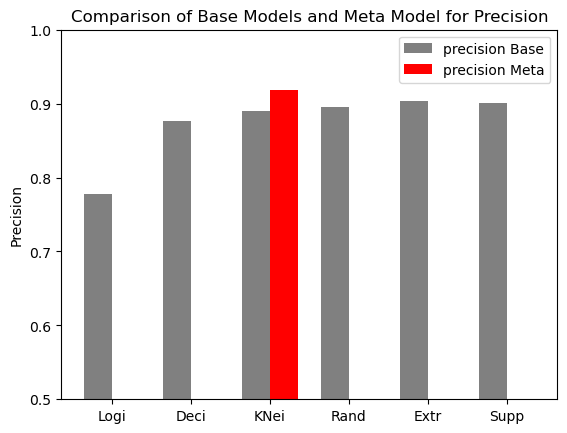

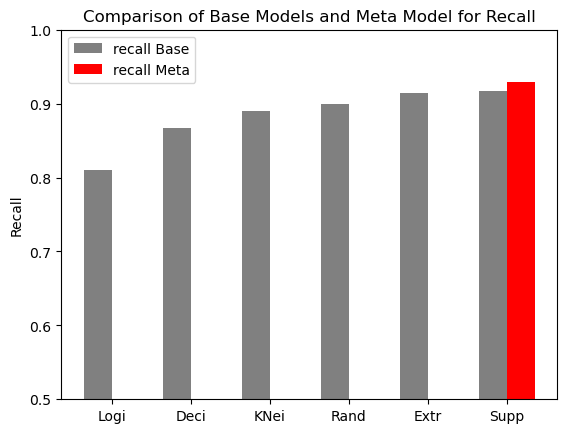

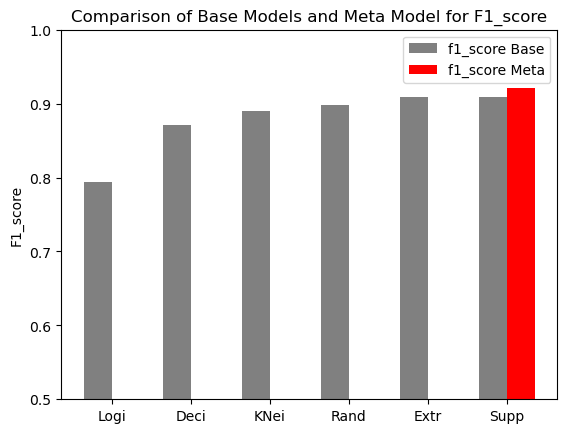

In [18]:
import matplotlib.pyplot as plt

df = result
metrics = ['Accuracy', 'precision', 'recall', 'f1_score']

# Create plots
for metric in metrics:
    highest_meta = df[f'{metric}_meta'].max()
    highest_meta_model = df[df[f'{metric}_meta'] == highest_meta]['Model'].values[0]
    # Index base and meta models
    base_values = df[f'{metric}_base']
    meta_values = [highest_meta if model == highest_meta_model else 0 for model in df['Model']]
    # Set up bar locations
    x = np.arange(len(df['Model']))  # the label locations
    width = 0.35  # the width of the bars

    # Plotting
    plt.figure()
    bars1 = plt.bar(x - width/2, base_values, width, label=f'{metric} Base', color='gray')
    bars2 = plt.bar(x + width/2, meta_values, width, label=f'{metric} Meta', color='red')
    
    # Add labels, title, and custom x-axis tick labels
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of Base Models and Meta Model for {metric.capitalize()}')
    plt.xticks(x, df['Model'])
    plt.ylim(0.5, 1.0)  
    plt.legend()

    plt.show()